In [1]:
import os, sys
sys.path.append('../CommonUtils/')
import CommonUtils as cu
import pandas as pd
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load data from CSV

In [2]:
df_data=pd.read_csv("../DATA/misc/df_binned.csv")
df_info=pd.read_csv("../DATA/misc/df_info.csv")

### Assign variables from the DF

In [3]:
x=df_data['bincenters']
y=df_data['ymean']
x_err=df_data['xerr']
y_err=df_data['yerr']

# Now perfrom a fit in simulation with the constants phase of 6.240(8) rad 
$$\theta(t) = A_{\mu}\cos(\omega t + \phi) + A_{\mathrm{EDM}}\sin(\omega t + \phi) + c$$
where  
[0] $A_{\mu}$ is the $g-2$ amplitude  
[1] $A_{\mathrm{EDM}}$ is the EDM amplitude  
[2] $c$ is the offset in the central angle  
[3] $\omega$ is the anomalous precision frequency  

In [16]:
# phi = 6.240
phi = - 0.043

sys.path.append("../Blinding/") # folder with Blinders and libBlinders.so
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
getBlinded = Blinders(FitType.Omega_a, "EDM all day") 


def thetaY_blinded(t, *pars):
    A_mu  = pars[0]      
    A_edm = pars[1]    
    c     = pars[2]    
    R     = pars[3]
    
    omega = getBlinded.paramToFreq(R)
#     omega = R
    return A_mu * np.cos(omega * t + phi) + A_edm * np.sin(omega  * t + phi) + c

#function, X, Y, [starting par]
# Levenberg-Marquardt algorithm as implemented in MINPACK
par, pcov = optimize.curve_fit(thetaY_blinded, x, y, sigma=y_err, p0=[0.0, 0.14, 0.02, 100], absolute_sigma=False, method='lm')

par_e = np.sqrt(np.diag(pcov))

print("Params:", par)
print("Errors:", par_e)
chi2_ndf, chi2, ndf=cu.chi2_ndf(x, y, y_err, thetaY_blinded, par)
print("𝝌2/DoF",(round(chi2_ndf,2)) )

Params: [-2.10763949e-02  1.39519142e-01  2.01077688e-02 -1.76652007e+04]
Errors: [3.56511376e-02 1.64689795e-02 1.25294759e-02 7.78235656e+04]
𝝌2/DoF 1.15


  $\frac{\chi^2}{DoF}$=1.15

$ A_{\mu}$=-0.02(4) mrad
$ A_{\rm{EDM}}$=+0.14(2) mrad
c=+0.02(1) mrad
$\omega$=-17665.20(7782357) MhZ



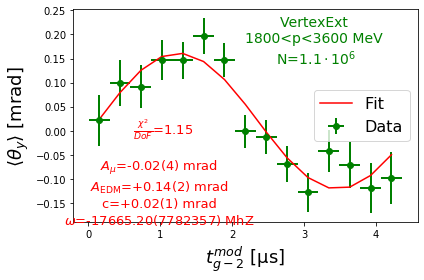

In [17]:
fig, ax = plt.subplots()
ax.errorbar(x,y,xerr=x_err, yerr=y_err, linewidth=0, elinewidth=2, color="green", marker="o", label="Data")
ax.plot(x, thetaY_blinded(x, *par), color="red", label='Fit')
ax.legend(loc='best')
ax.set_ylabel(df_info['y_label'][0], fontsize=16)
ax.set_xlabel(df_info['x_label'][0], fontsize=16)

# deal with fitter parameters
parNames=[r"$ A_{\mu}$", r"$ A_{\rm{EDM}}$", "c", r"$\omega$"]
units=["mrad", "mrad", "mrad", "MhZ"]
prec=2
#form complex legends 
legend1_chi2=cu.legend1_fit(chi2_ndf)
legned1_par=""
legned1_par=cu.legend_par(legned1_par,  parNames, par, par_e, units)
legend1=legend1_chi2+"\n"+legned1_par
print(legend1)
legend2=df_info['data_type'][0]+"\n"+df_info["p_cut"][0]+"\n N="+cu.sci_notation(df_info['N'][0])

#place on the plot and save 
y1,y2,x1,x2=0.2,0.85,0.25,0.70
cu.textL(ax, x1, y1, legend1, font_size=13, color="red")    
cu.textL(ax, x2, y2, legend2, font_size=14)
ax.legend(loc='center right', fontsize=16)
ax.set_ylabel(df_info['y_label'][0], fontsize=18)
ax.set_xlabel(df_info['x_label'][0], fontsize=18)
plt.tight_layout() 

plt.savefig("../fig/testFit.png", dpi=300)